In [71]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import OrthogonalMatchingPursuit
import copy
from collections import Counter

import warnings

# Filtrer les avertissements spécifiques
warnings.filterwarnings("ignore", message="Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary")

In [33]:
def bin_to_pattern(x):
    return [ [1-int(i), int(i)] for i in x ]
def create_specific_patterns(mode1,mode2,size):
    pats =[]
    for i in range(2):
        for j in range(2):
            pats.append( [[1,1]]*mode1 + bin_to_pattern(str(i)) + [[1,1]]*(mode2-mode1-1) + bin_to_pattern(str(j)) + [[1,1]]*(size-mode1-(mode2-mode1-1)-2) )
    return pats
def create_specific_patterns3(mode1,mode2,mode3,size):
    pats =[]
    for i in range(2):
        for j in range(2):
            for k in range(2):
                pats.append( [[1,1]]*mode1 + bin_to_pattern(str(i)) + [[1,1]]*(mode2-mode1-1) + bin_to_pattern(str(j)) + [[1,1]]*(mode3-(mode2-mode1-1)-mode1-2) + bin_to_pattern(str(k)) + [[1,1]]*(size -mode1-(mode2-mode1-1)-(mode3-(mode2-mode1-1)-mode1-2)-3) )
    return pats
def create_specific_patterns4(mode1,mode2,mode3,mode4,size):
    pats = []
    temp_pats = create_specific_patterns3(mode1,mode2,mode3,size)
    for p in temp_pats:
        for k in range(2):
            p_prime = copy.deepcopy(p)
            p_prime[mode4] = bin_to_pattern(str(k))[0]
            pats.append(p_prime)
    return pats
def create_specific_patterns5(mode1, mode2, mode3, mode4, mode5, size):
    """
    Generate specific patterns for 5 modes.
    """
    pats = []
    temp_pats = create_specific_patterns4(mode1, mode2, mode3, mode4, size)
    for p in temp_pats:
        for k in range(2):
            p_prime = copy.deepcopy(p)
            p_prime[mode5] = bin_to_pattern(str(k))[0]
            pats.append(p_prime)
    return pats
def create_specific_patterns8(mode1, mode2, mode3, mode4, mode5, mode6, mode7, mode8, size):
    """
    Generate specific patterns for 8 modes.
    """
    pats = []
    temp_pats = create_specific_patterns5(mode1, mode2, mode3, mode4, mode5, size)
    for p in temp_pats:
        for k in range(2):
            p_prime = copy.deepcopy(p)
            p_prime[mode6] = bin_to_pattern(str(k))[0]
            for l in range(2):
                p_prime2 = copy.deepcopy(p_prime)
                p_prime2[mode7] = bin_to_pattern(str(l))[0]
                for m in range(2):
                    p_prime3 = copy.deepcopy(p_prime2)
                    p_prime3[mode8] = bin_to_pattern(str(m))[0]
                    pats.append(p_prime3)
    return pats
def dev_pattern(pat):
    f = np.array([1])
    for i in pat:
        f = np.kron(f,i)
    return f

<h2>Game modeling</h2>

In [34]:
def stringify(seq):
    string = ''
    for n in seq:
        string+=str(n)
    return string

In [36]:
n = 12
sequence_list = np.array([np.array(list(bin(i)[3:]),dtype=np.int32) for i in range(2**n, 2**(n+1))])
len(sequence_list)

4096

In [56]:
def generate_rules_and_rewards(num_rules=5, rule_length=4, reward_range=(1, 20), sequence_length=12):
    """
    Generate rules, rewards, and starting positions for the rules.
    """
    rules = set()
    rewards = []
    starting_positions = []

    while len(rules) < num_rules:
        rule = tuple(np.random.randint(0, 2, size=rule_length))  # Generate a random rule
        if rule not in rules:
            rules.add(rule)
            reward = np.random.randint(reward_range[0], reward_range[1])  # Generate a random reward
            rewards.append(reward)
            # Generate one or more starting positions for the rule
            positions = np.random.choice(range(sequence_length - rule_length + 1), size=np.random.randint(1, 12-rule_length), replace=False)
            starting_positions.append(list(positions))

    return list(rules), rewards, starting_positions


def estimate_cost(sequence, rules, rewards, starting_positions=None):
    """
    Estimate the cost of a sequence based on the rules, rewards, and starting positions.
    """
    if rules== [] or rewards == []:
        return 0

    if starting_positions is None:
        starting_positions = [list(range(len(sequence) - len(rules[0]) + 1))] * len(rules)

    reward = 0
    rule_length = len(rules[0])

    for rule, rule_reward, positions in zip(rules, rewards, starting_positions):
        for k in positions:  # Only check the specified starting positions
            if k + rule_length <= len(sequence) and np.all(sequence[k:k + rule_length] == rule):
                reward += rule_reward
                break  # Stop checking further positions for this rule if it matches

    return np.abs(reward)

In [384]:
def monte_carlo_compressive_learning(Phi,sequence_cost,sample_size=200,threshold=20):

    #Sample
    sample_index = np.random.randint(0,len(sequence_list),sample_size)
    sequence_cost_spectrum = np.zeros_like(sequence_cost)
    sequence_cost_spectrum[sample_index] = sequence_cost[sample_index]

    #Threshold
    sequence_cost_spectrum[sequence_cost_spectrum<threshold]=0

    #Measurements
    y = []
    y = np.array(Phi * np.matrix(sequence_cost_spectrum).T).T[0]
    y = np.array(y)

    #Matching pursuit
    omp = OrthogonalMatchingPursuit(n_nonzero_coefs=10)
    omp.fit(Phi, y)
    coefficients = np.array([ i if i>0 else 0 for i in omp.coef_])

    support = np.where(coefficients>0)[0]
    if len(support) != 0:
        maximum = np.max(sequence_cost[support])
        argmax = support[np.argmax(sequence_cost[support])]

        return (argmax,maximum)
    else:
        return (None,0)

In [225]:
from scipy.optimize import dual_annealing

# Define the objective function
def my_f(x):
    """
    Objective function to minimize.
    Converts x to an integer index and returns the negative sequence cost.
    """
    x = int(round(x[0]))  # Ensure x is a single integer index
    if 0 <= x < len(sequence_cost):  # Check bounds
        return -sequence_cost[x]
    else:
        return float('inf')  # Return a large value if out of bounds

# Define bounds for the single-dimensional problem
bounds = [(0, len(sequence_cost) - 1)]  # Single-dimensional bounds

In [329]:
import numpy as np

def random_repartition(nb_rules,into=5):
    """
    Generate a random repartition of 5 values whose sum equals nb_rules.
    """
    values = np.random.multinomial(nb_rules, [1/into]*into)
    return values


<h2>Tests</h2>

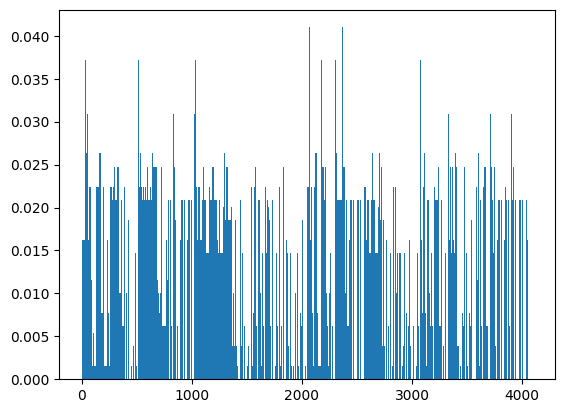

0.04099048526308849

In [402]:
def generate_problem(total_nb_rules=5):
    nb_rules = random_repartition(total_nb_rules,into=3)

    rules1, rewards1,pos1 = generate_rules_and_rewards(num_rules=nb_rules[0],rule_length=4)
    rules2, rewards2,pos2 = generate_rules_and_rewards(num_rules=nb_rules[1],rule_length=5)
    rules3, rewards3,pos3 = generate_rules_and_rewards(num_rules=nb_rules[2],rule_length=6)
    # pos1 = [[0,2,4,6,8]]*nb_rules
    # pos1 = [np.arange(0,4)]*nb_rules
    # pos1 = [ [i] for i in np.random.randint(0,8,nb_rules)]

    sequence_cost = []
    for sequence in sequence_list:
        rew = 0
        rew += estimate_cost(sequence,rules1, rewards1)
        rew += estimate_cost(sequence,rules2, rewards2)
        rew += estimate_cost(sequence,rules3, rewards3)
        sequence_cost.append(rew)
    sequence_cost = np.array(sequence_cost)
    sequence_cost = sequence_cost /np.linalg.norm(sequence_cost)

    return sequence_cost

sequence_cost = generate_problem(5)
real_argmax = np.argmax(sequence_cost)
real_maximum = sequence_cost[real_argmax]
plt.bar([i for i in np.arange(len(sequence_list))],sequence_cost,width=1.5)
plt.show()
real_maximum

In [ ]:
#Random
Phi_random = np.random.rand(250,2**n)

#Quadruplets
all_pat = []
for i in range(n-3):
    all_pat += create_specific_patterns4(i,i+1,i+2,i+3,n)
Phi_quad = np.array([dev_pattern(p) for p in all_pat])

#Quintuplets
all_pat = []
for i in range(n-4):
    all_pat += create_specific_patterns5(i,i+1,i+2,i+3,i+4,n)
Phi_quint = np.array([dev_pattern(p) for p in all_pat])

#Parameters
sample_size = 200
thresh = np.percentile(sequence_cost,90)

plot_res = {}
plot_res["annealing"] = []
plot_res["random"] = []
plot_res["quadruplets"] = []
plot_res["quintuplets"] = []

rg = np.concatenate((np.arange(50,140,10),np.arange(150,400,25)))

for sample_size in rg:
    print(sample_size)

    average_distance = {}
    average_distance["annealing"] = []
    average_distance["random"] = []
    average_distance["quadruplets"] = []
    average_distance["quintuplets"] = []

    for _ in range(1200):
        
        # Annealing
        res = dual_annealing(my_f, bounds=bounds, maxiter=sample_size,no_local_search=True)
        argmax = round(res.x[0])
        maximum = -res.fun
        average_distance["annealing"].append(np.max(sequence_cost) - maximum)

        #Random
        argmax,maximum = monte_carlo_compressive_learning(Phi_random,sequence_cost,sample_size=sample_size,threshold=thresh)
        average_distance["random"].append(np.max(sequence_cost) - maximum)

        #Quadruplets
        argmax,maximum = monte_carlo_compressive_learning(Phi_quad,sequence_cost,sample_size=sample_size,threshold=thresh)
        average_distance["quadruplets"].append(np.max(sequence_cost) - maximum)

        #Quintuplets
        argmax,maximum = monte_carlo_compressive_learning(Phi_quint,sequence_cost,sample_size=sample_size,threshold=thresh)
        average_distance["quintuplets"].append(np.max(sequence_cost) - maximum)

    plot_res["annealing"].append(round(np.average(average_distance["annealing"]),ndigits=5))
    plot_res["random"].append(round(np.average(average_distance["random"]),ndigits=5))
    plot_res["quadruplets"].append(round(np.average(average_distance["quadruplets"]),ndigits=5))
    plot_res["quintuplets"].append(round(np.average(average_distance["quintuplets"]),ndigits=5))

50
60
70
80
90
100
110
120


In [467]:
# Save plot_res to a file
with open("one_problem_curve2.json", "w") as file:
    json.dump(plot_res, file)

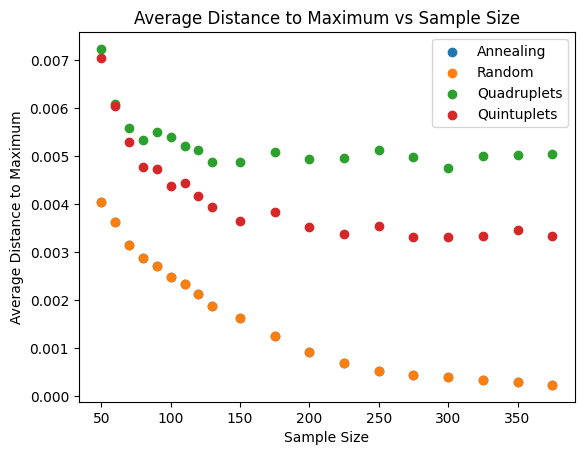

In [468]:
rg = np.concatenate((np.arange(50,140,10),np.arange(150,400,25)))
plt.scatter(rg,plot_res["annealing"],label="Annealing")
plt.scatter(rg,plot_res["random"],label="Random")
plt.scatter(rg,plot_res["quadruplets"],label="Quadruplets")
plt.scatter(rg,plot_res["quintuplets"],label="Quintuplets")
plt.xlabel("Sample Size")
plt.ylabel("Average Distance to Maximum")
plt.title("Average Distance to Maximum vs Sample Size")
plt.legend()
plt.show()

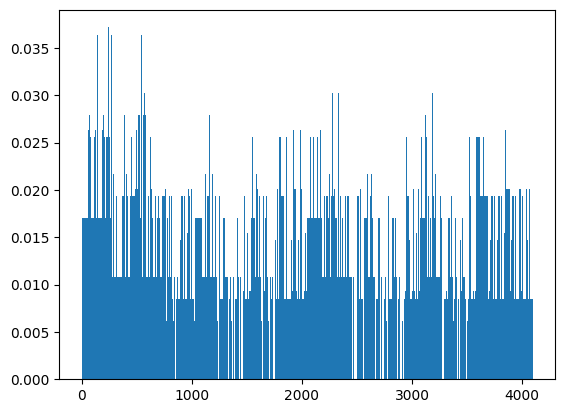

0.03718323560402179

In [ ]:
sequence_cost = generate_problem(5)
real_argmax = np.argmax(sequence_cost)
real_maximum = sequence_cost[real_argmax]
plt.bar([i for i in np.arange(len(sequence_list))],sequence_cost,width=1.5)
plt.show()
real_maximum

In [391]:
#Random
Phi_random = np.random.rand(250,2**n)

#Quadruplets
all_pat = []
for i in range(n-3):
    all_pat += create_specific_patterns4(i,i+1,i+2,i+3,n)
Phi_quad = np.array([dev_pattern(p) for p in all_pat])

#Quintuplets
all_pat = []
for i in range(n-4):
    all_pat += create_specific_patterns5(i,i+1,i+2,i+3,i+4,n)
Phi_quint = np.array([dev_pattern(p) for p in all_pat])

plot_res = {}
plot_res["annealing"] = []
plot_res["random"] = []
plot_res["quadruplets"] = []
plot_res["quintuplets"] = []

for sample_size in np.arange(50,400,25):
    print(sample_size)

    average_over_problem = {}
    average_over_problem["annealing"] = []
    average_over_problem["random"] = []
    average_over_problem["quadruplets"] = []
    average_over_problem["quintuplets"] = []

    for prob in range(100):
        print(prob)

        sequence_cost = generate_problem(5)

        #Parameters
        thresh = np.percentile(sequence_cost,90)

        average_distance = {}
        average_distance["annealing"] = []
        average_distance["random"] = []
        average_distance["quadruplets"] = []
        average_distance["quintuplets"] = []

        for _ in range(200):
            
            # Annealing
            res = dual_annealing(my_f, bounds=bounds, maxiter=sample_size,no_local_search=True)
            argmax = round(res.x[0])
            maximum = -res.fun
            average_distance["annealing"].append(np.max(sequence_cost) - maximum)

            #Random
            argmax,maximum = monte_carlo_compressive_learning(Phi_random,sequence_cost,sample_size=sample_size,threshold=thresh)
            average_distance["random"].append(np.max(sequence_cost) - maximum)

            #Quadruplets
            argmax,maximum = monte_carlo_compressive_learning(Phi_quad,sequence_cost,sample_size=sample_size,threshold=thresh)
            average_distance["quadruplets"].append(np.max(sequence_cost) - maximum)

            #Quintuplets
            argmax,maximum = monte_carlo_compressive_learning(Phi_quint,sequence_cost,sample_size=sample_size,threshold=thresh)
            average_distance["quintuplets"].append(np.max(sequence_cost) - maximum)

        average_over_problem["annealing"].append(np.average(average_distance["annealing"]))
        average_over_problem["random"].append(np.average(average_distance["random"]))
        average_over_problem["quadruplets"].append(np.average(average_distance["quadruplets"]))
        average_over_problem["quintuplets"].append(np.average(average_distance["quintuplets"]))

    plot_res["annealing"].append(np.average(average_over_problem["annealing"]))
    plot_res["random"].append(np.average(average_over_problem["random"]))
    plot_res["quadruplets"].append(np.average(average_over_problem["quadruplets"]))
    plot_res["quintuplets"].append(np.average(average_over_problem["quintuplets"]))

50
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
75
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
125
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41


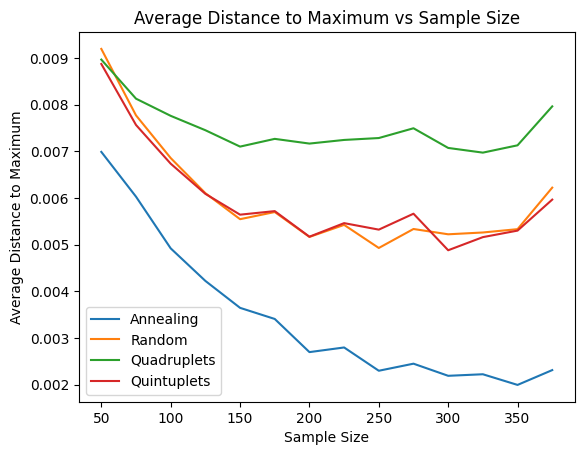

In [393]:
plt.plot(np.arange(50,400,25),plot_res["annealing"],label="Annealing")
plt.plot(np.arange(50,400,25),plot_res["random"],label="Random")
plt.plot(np.arange(50,400,25),plot_res["quadruplets"],label="Quadruplets")
plt.plot(np.arange(50,400,25),plot_res["quintuplets"],label="Quintuplets")
plt.xlabel("Sample Size")
plt.ylabel("Average Distance to Maximum")
plt.title("Average Distance to Maximum vs Sample Size")
plt.legend()
plt.show()